# Assignment 9: DonorsChoose_RF_GBDT

<h2>Data splitting and pre-processing</h2>

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


import pickle
from tqdm import tqdm
import os
from collections import Counter



In [0]:
from google.colab import drive
drive.mount("/content/drive")

project_data = pd.read_csv('/content/drive/My Drive/train_data.csv')
resource_data = pd.read_csv('/content/drive/My Drive/resources.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
project_data.isnull().sum()

Unnamed: 0                                           0
id                                                   0
teacher_id                                           0
teacher_prefix                                       3
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105490
project_essay_4                                 105490
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64

In [0]:
#filling 3 null teacher prefix values with Teacher

project_data["teacher_prefix"].fillna("Teacher",inplace = True)
project_data.isnull().sum()

Unnamed: 0                                           0
id                                                   0
teacher_id                                           0
teacher_prefix                                       0
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105490
project_essay_4                                 105490
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [0]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [0]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109248 entries, 0 to 109247
Data columns (total 20 columns):
Unnamed: 0                                      109248 non-null int64
id                                              109248 non-null object
teacher_id                                      109248 non-null object
teacher_prefix                                  109248 non-null object
school_state                                    109248 non-null object
project_submitted_datetime                      109248 non-null object
project_grade_category                          109248 non-null object
project_subject_categories                      109248 non-null object
project_subject_subcategories                   109248 non-null object
project_title                                   109248 non-null object
project_essay_1                                 109248 non-null object
project_essay_2                                 109248 non-null object
project_essay_3                       

**Considering only 20k train , 5k validation and 5k test data points**

In [0]:
from sklearn.utils import resample
p_d = resample(project_data,n_samples = 30000)

In [0]:
#splitting data as 30% to test
y = p_d["project_is_approved"]
X = p_d
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.16, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.19, random_state=42)

In [0]:
print(X_train.shape," ",y_train.shape)
print(X_test.shape," ",y_test.shape)
print(X_val.shape," ",y_val.shape)

(20412, 20)   (20412,)
(4800, 20)   (4800,)
(4788, 20)   (4788,)


**Function for Response coding**

In [0]:
# function for response coding



def get_gv_fea_dict(alpha, feature, df):
    value_count = X_train[feature].value_counts()
    gv_dict = dict()
    
    for i, denominator in value_count.items():
        vec = []
        for k in range(2):
            cls_cnt = X_train.loc[(X_train['project_is_approved']==k) & (X_train[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 20*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

def response_encode(alpha, feature, df):
    """
    This function calculates probability of category belonging to class 1.
    As there are only two classes. so P(y=0/C) = 1 - P(y=1/c)
    
    Returns dictionary of # elements in positive class and their probabilites.
    
    """
    
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = X_train[feature].value_counts()
    
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/2,1/2])
    return gv_fea

<h3>Preprocessing categorical Features</h3>

1. project subject categories

In [0]:
#using code from assignment
# project subject categories
catogories = list(X_train['project_subject_categories'].values)

cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_') 
    cat_list.append(temp.strip())
    
X_train['clean_categories'] = cat_list
X_train.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in X_train['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


# project subject categories for test data

catogories = list(X_test['project_subject_categories'].values)

cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_') 
    cat_list.append(temp.strip())
    
X_test['clean_categories'] = cat_list
X_test.drop(['project_subject_categories'], axis=1, inplace=True)

# project subject categories for test data

catogories = list(X_val['project_subject_categories'].values)

cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_') 
    cat_list.append(temp.strip())
    
X_val['clean_categories'] = cat_list
X_val.drop(['project_subject_categories'], axis=1, inplace=True)


In [0]:
alpha = 1
categories_feature_responseCoding = np.array(response_encode(alpha, "clean_categories", X_train))
val_categories_feature_responseCoding = np.array(response_encode(alpha, "clean_categories", X_val))
test_categories_feature_responseCoding = np.array(response_encode(alpha, "clean_categories", X_test))

2. project subject sub_categories

In [0]:
sub_catogories = list(X_train['project_subject_subcategories'].values)
sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') 
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

X_train['clean_subcategories'] = sub_cat_list
X_train.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in X_train['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


sub_catogories = list(X_test['project_subject_subcategories'].values)
sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') 
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

X_test['clean_subcategories'] = sub_cat_list
X_test.drop(['project_subject_subcategories'], axis=1, inplace=True)


# for validation data set
sub_catogories = list(X_val['project_subject_subcategories'].values)
sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') 
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

X_val['clean_subcategories'] = sub_cat_list
X_val.drop(['project_subject_subcategories'], axis=1, inplace=True)

In [0]:
alpha = 1
subcategories_feature_responseCoding = np.array(response_encode(alpha, "clean_subcategories", X_train))
val_subcategories_feature_responseCoding = np.array(response_encode(alpha, "clean_subcategories", X_val))
test_subcategories_feature_responseCoding = np.array(response_encode(alpha, "clean_subcategories", X_test))

In [0]:
len(subcategories_feature_responseCoding)

20412

3. Teacher Prefix

In [0]:
#preprocessing teacher prefix
prefix = list(X_train['teacher_prefix'].values)
prefix_list = []
for i in prefix:
    temp = ""
    if "." in i: 
            i=i.replace('.','') 
    temp+=i.strip()+" " 
    prefix_list.append(temp.strip())
    
X_train['clean_prefix'] = prefix_list

my_counter = Counter()
for word in X_train['clean_prefix'].values:
  my_counter.update(word.split())

prefix_dict = dict(my_counter)
sorted_prefix_dict = dict(sorted(prefix_dict.items(), key=lambda kv: kv[1]))
print(sorted_prefix_dict)


#preprocessing teacher prefix for test data
prefix = list(X_test['teacher_prefix'].values)
prefix_list = []
for i in prefix:
    temp = ""
    if "." in i: 
            i=i.replace('.','') 
    temp+=i.strip()+" " 
    prefix_list.append(temp.strip())
    
X_test['clean_prefix'] = prefix_list

#preprocessing teacher prefix for val data
prefix = list(X_val['teacher_prefix'].values)
prefix_list = []
for i in prefix:
    temp = ""
    if "." in i: 
            i=i.replace('.','') 
    temp+=i.strip()+" " 
    prefix_list.append(temp.strip())
    
X_val['clean_prefix'] = prefix_list

{'Dr': 4, 'Teacher': 419, 'Mr': 1922, 'Ms': 7247, 'Mrs': 10820}


In [0]:
alpha = 1
# train gene feature
prefix_feature_responseCoding = np.array(response_encode(alpha, "clean_prefix", X_train))
val_prefix_feature_responseCoding = np.array(response_encode(alpha, "clean_prefix", X_val))
test_prefix_feature_responseCoding = np.array(response_encode(alpha, "clean_prefix", X_test))

4. Project Grade Category

In [0]:
# preprocessing of grade category for train data

grade = list(X_train['project_grade_category'].values)
grade_list = []
for i in grade:
    temp = ""
    if "Grades" in i:
      i = i.replace("Grades","")
    if "6-8" in i:
      i = i.replace("6-8","six_eight")
    if "3-5" in i:
      i = i.replace("3-5","three_five")
    if "9-12" in i:
      i = i.replace("9-12","nine_twelve")
    if "PreK-2" in i:
      i = i.replace("PreK-2","prek_two")
    temp+=i.strip()+" " 
    grade_list.append(temp.strip())
    
X_train['clean_grade'] = grade_list

my_counter = Counter()
for word in X_train['clean_grade'].values:
  my_counter.update(word.split())

grade_dict = dict(my_counter)
sorted_grade_dict = dict(sorted(grade_dict.items(), key=lambda kv: kv[1]))
print(sorted_grade_dict)

# preprocessing of grade category for test data

grade = list(X_test['project_grade_category'].values)
grade_list = []
for i in grade:
    temp = ""
    if "Grades" in i:
      i = i.replace("Grades","")
    if "6-8" in i:
      i = i.replace("6-8","six_eight")
    if "3-5" in i:
      i = i.replace("3-5","three_five")
    if "9-12" in i:
      i = i.replace("9-12","nine_twelve")
    if "PreK-2" in i:
      i = i.replace("PreK-2","prek_two")
    temp+=i.strip()+" " 
    grade_list.append(temp.strip())
    
X_test['clean_grade'] = grade_list


grade = list(X_val['project_grade_category'].values)
grade_list = []
for i in grade:
    temp = ""
    if "Grades" in i:
      i = i.replace("Grades","")
    if "6-8" in i:
      i = i.replace("6-8","six_eight")
    if "3-5" in i:
      i = i.replace("3-5","three_five")
    if "9-12" in i:
      i = i.replace("9-12","nine_twelve")
    if "PreK-2" in i:
      i = i.replace("PreK-2","prek_two")
    temp+=i.strip()+" " 
    grade_list.append(temp.strip())
    
X_val['clean_grade'] = grade_list

{'nine_twelve': 2025, 'six_eight': 3119, 'three_five': 6950, 'prek_two': 8318}


In [0]:
alpha = 1
# train gene feature
grade_feature_responseCoding = np.array(response_encode(alpha, "clean_grade", X_train))
val_grade_feature_responseCoding = np.array(response_encode(alpha, "clean_grade", X_val))
test_grade_feature_responseCoding = np.array(response_encode(alpha, "clean_grade", X_test))

5. School State

In [0]:
#no need of preprocessing on school state

state = X_train["school_state"].value_counts()
sorted_state = dict(state)
sorted_state_dict = dict(sorted(sorted_state.items(), key=lambda kv: kv[1]))
X_train["clean_state"] = X_train["school_state"]

#similarly for X_test
X_test["clean_state"] = X_test["school_state"]

#similarly for X_val
X_val["clean_state"] = X_val["school_state"]

In [0]:
alpha = 1
# train gene feature
state_feature_responseCoding = np.array(response_encode(alpha, "clean_state", X_train))
val_state_feature_responseCoding = np.array(response_encode(alpha, "clean_state", X_val))
test_state_feature_responseCoding = np.array(response_encode(alpha, "clean_state", X_test))

<h3>Preprocessing Numerical Feature</h3>

1. Standardizing price

In [0]:
from sklearn.preprocessing import StandardScaler


price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) 
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

#train data price standardization
price_standardized = price_scalar.transform(X_train['price'].values.reshape(-1, 1))

#val data price stanardization. Fit method applied on X_train
val_price_standardized = price_scalar.transform(X_val['price'].values.reshape(-1, 1))


#test data price stanardization. Fit method applied on X_train
test_price_standardized = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


2. Standardizing quantity

In [0]:
price_scalar = StandardScaler()
price_scalar.fit(X_train["quantity"].values.reshape(-1, 1))
print(f"Mean of Quantity : {price_scalar.mean_[0]}, Standard deviation of Quantity : {np.sqrt(price_scalar.var_[0])}")

#train data quantity standardization
quantity_standardized = price_scalar.transform(X_train["quantity"].values.reshape(-1, 1))

#val data quantity stanardization. Fit method applied on X_train
val_quantity_standardized = price_scalar.transform(X_val["quantity"].values.reshape(-1, 1))

#test data quantity stanardization. Fit method applied on X_train
test_quantity_standardized = price_scalar.transform(X_test["quantity"].values.reshape(-1, 1))

Mean of Quantity : 16.62997256515775, Standard deviation of Quantity : 24.470232692115985


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


3. Standardizing number of ppp

In [0]:
price_scalar = StandardScaler()
price_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) 
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

#train data ppp standardization
number_ppp_standardized = price_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

#val data price stanardization. Fit method applied on X_train
val_number_ppp_standardized = price_scalar.transform(X_val['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

#test data price stanardization. Fit method applied on X_train
test_number_ppp_standardized = price_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 10.949686458945719, Standard deviation : 27.498824488079613


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


<h3>Preprocessing of Text Feature for both test and train data</h3>

In [0]:
#using function and stopwords form assignemnt

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
  
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

1. preprocessing of project essay

In [0]:
from tqdm import tqdm

#for train data
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
    
val_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_val['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    val_preprocessed_essays.append(sent.lower().strip())

    
    
test_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    test_preprocessed_essays.append(sent.lower().strip())

100%|██████████| 4800/4800 [00:02<00:00, 1637.56it/s]


2. preprocessing of project title

In [0]:
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())
    
# for val data
val_preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(X_val['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    val_preprocessed_title.append(sent.lower().strip())
    
    
# for test data
test_preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    test_preprocessed_title.append(sent.lower().strip())


100%|██████████| 4800/4800 [00:00<00:00, 32158.74it/s]


<h3>Vectorizing Text Feature</h3>

1. BOW

In [0]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
#fit using train data
vectorizer.fit(preprocessed_essays)
essay_feature = vectorizer.get_feature_names()


# for train data
text_bow = vectorizer.transform(preprocessed_essays)
print("Shape of train matrix : ",text_bow.shape)

# for val data
val_text_bow = vectorizer.transform(val_preprocessed_essays)


# for test data
test_text_bow = vectorizer.transform(test_preprocessed_essays)
print("Shape of test matrix : ",test_text_bow.shape)


# for title
vectorizer.fit(preprocessed_title)
title_feature = vectorizer.get_feature_names()

# for train data
title_bow = vectorizer.transform(preprocessed_title)
print("Shape of train matrix : ",title_bow.shape)

# for val data
val_title_bow = vectorizer.transform(val_preprocessed_title)
print("Shape of test matrix : ",val_title_bow.shape)

# for test data
test_title_bow = vectorizer.transform(test_preprocessed_title)
print("Shape of test matrix : ",test_title_bow.shape)

Shape of train matrix :  (20412, 5000)
Shape of test matrix :  (4800, 5000)
Shape of train matrix :  (20412, 1823)
Shape of test matrix :  (4788, 1823)
Shape of test matrix :  (4800, 1823)


2. TFIDF

In [0]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
#fit using train data
vectorizer.fit(preprocessed_essays)
essay_feature_tfidf = vectorizer.get_feature_names()
# for train data
text_tfidf = vectorizer.transform(preprocessed_essays)
print("Shape of train matrix : ",text_tfidf.shape)


# for val data
val_text_tfidf = vectorizer.transform(val_preprocessed_essays)
print("Shape of val matrix : ",val_text_tfidf.shape)

# for test data
test_text_tfidf = vectorizer.transform(test_preprocessed_essays)
print("Shape of test matrix : ",test_text_tfidf.shape)


# for title
vectorizer.fit(preprocessed_title)
title_feature_tfidf = vectorizer.get_feature_names()

# for train data
title_tfidf = vectorizer.transform(preprocessed_title)
print("Shape of train matrix : ",title_tfidf.shape)

# for val data
val_title_tfidf = vectorizer.transform(val_preprocessed_title)
print("Shape of val matrix : ",val_title_tfidf.shape)


# for test data
test_title_tfidf = vectorizer.transform(test_preprocessed_title)
print("Shape of test matrix : ",test_title_tfidf.shape)

Shape of train matrix :  (20412, 5000)
Shape of val matrix :  (4788, 5000)
Shape of test matrix :  (4800, 5000)
Shape of train matrix :  (20412, 1823)
Shape of val matrix :  (4788, 1823)
Shape of test matrix :  (4800, 1823)


3. Avg W2v

In [0]:
with open('/content/drive/My Drive/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# for train data
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)
print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))


# for val data
val_avg_w2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(val_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    val_avg_w2v_vectors.append(vector)

print(len(val_avg_w2v_vectors))
print(len(val_avg_w2v_vectors[0]))

    
# for test data
test_avg_w2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_avg_w2v_vectors.append(vector)

print(len(test_avg_w2v_vectors))
print(len(test_avg_w2v_vectors[0]))

  6%|▌         | 292/4788 [00:00<00:01, 2916.66it/s]

20412
300


 12%|█▏        | 591/4800 [00:00<00:01, 2965.03it/s]

4788
300


100%|██████████| 4800/4800 [00:01<00:00, 2921.10it/s]

4800
300


In [0]:
title_avg_w2v_vectors = []
for sentence in tqdm(preprocessed_title): 
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split(): 
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    title_avg_w2v_vectors.append(vector)

print(len(title_avg_w2v_vectors))
print(len(title_avg_w2v_vectors[0]))

# for val data
val_title_avg_w2v_vectors = []
for sentence in tqdm(val_preprocessed_title): 
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split(): 
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    val_title_avg_w2v_vectors.append(vector)

print(len(val_title_avg_w2v_vectors))
print(len(val_title_avg_w2v_vectors[0]))


# for test data
test_title_avg_w2v_vectors = []
for sentence in tqdm(test_preprocessed_title): 
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split(): 
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_title_avg_w2v_vectors.append(vector)

print(len(test_title_avg_w2v_vectors))
print(len(test_title_avg_w2v_vectors[0]))


100%|██████████| 4800/4800 [00:00<00:00, 64242.98it/s]

20412
300
4788
300
4800
300


4. TFIDF avgw2v

In [0]:
#  for train data
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

# -------------- for val data --------------------------
val_tfidf_model = TfidfVectorizer()
val_tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(val_tfidf_model.get_feature_names(), list(val_tfidf_model.idf_)))
tfidf_words = set(val_tfidf_model.get_feature_names())

val_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(val_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    val_tfidf_w2v_vectors.append(vector)

print(len(val_tfidf_w2v_vectors))
print(len(val_tfidf_w2v_vectors[0]))




# ------------------ for test data ---------------------------
test_tfidf_model = TfidfVectorizer()
test_tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(test_tfidf_model.get_feature_names(), list(test_tfidf_model.idf_)))
tfidf_words = set(test_tfidf_model.get_feature_names())

test_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_vectors.append(vector)

print(len(test_tfidf_w2v_vectors))
print(len(test_tfidf_w2v_vectors[0]))


100%|██████████| 20412/20412 [00:41<00:00, 488.34it/s]


20412
300


100%|██████████| 4788/4788 [00:09<00:00, 480.30it/s]


4788
300


100%|██████████| 4800/4800 [00:10<00:00, 475.26it/s]

4800
300


In [0]:
# for title 
tfidf_model.fit(preprocessed_title)

dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    title_tfidf_w2v_vectors.append(vector)

print(len(title_tfidf_w2v_vectors))

# -------------- for val title -----------------------------
val_tfidf_model.fit(preprocessed_title)

dictionary = dict(zip(val_tfidf_model.get_feature_names(), list(val_tfidf_model.idf_)))
tfidf_words = set(val_tfidf_model.get_feature_names())


val_title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(val_preprocessed_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    val_title_tfidf_w2v_vectors.append(vector)

print(len(val_title_tfidf_w2v_vectors))



# --------------- for test title  ----------------------
test_tfidf_model.fit(preprocessed_title)

dictionary = dict(zip(test_tfidf_model.get_feature_names(), list(test_tfidf_model.idf_)))
tfidf_words = set(test_tfidf_model.get_feature_names())


test_title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(test_preprocessed_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_title_tfidf_w2v_vectors.append(vector)

print(len(test_title_tfidf_w2v_vectors))


  0%|          | 0/4788 [00:00<?, ?it/s]

20412


  0%|          | 0/4800 [00:00<?, ?it/s]

4788


100%|██████████| 4800/4800 [00:00<00:00, 20651.27it/s]

4800


Printing all

In [0]:
print("Text Features that are considered :- ")
print("*"*70)
print("Project Essay BOW:- ",text_bow.shape)
print("Project Essay TFIDF:- ",text_tfidf.shape)
print("*"*70)
print("Project Title BOW:- ",title_bow.shape)
print("Project Title TFIDF:- ",title_tfidf.shape)
print("*"*70)

Text Features that are considered :- 
**********************************************************************
Project Essay BOW:-  (20412, 5000)
Project Essay TFIDF:-  (20412, 5000)
**********************************************************************
Project Title BOW:-  (20412, 1823)
Project Title TFIDF:-  (20412, 1823)
**********************************************************************


In [0]:
avg_w2v_vectors = np.array(avg_w2v_vectors)
title_avg_w2v_vectors = np.array(title_avg_w2v_vectors)
val_avg_w2v_vectors = np.array(val_avg_w2v_vectors)

In [0]:
test_avg_w2v_vectors = np.array(test_avg_w2v_vectors)
test_title_avg_w2v_vectors = np.array(test_title_avg_w2v_vectors)

# sets

In [0]:
#combining all feature into one
from scipy.sparse import hstack

set1 = hstack((categories_feature_responseCoding,subcategories_feature_responseCoding,prefix_feature_responseCoding,grade_feature_responseCoding,state_feature_responseCoding,price_standardized,quantity_standardized,number_ppp_standardized,text_bow,title_bow))
set1_v = hstack((val_categories_feature_responseCoding,val_subcategories_feature_responseCoding,val_prefix_feature_responseCoding,val_grade_feature_responseCoding,val_state_feature_responseCoding,val_price_standardized,val_quantity_standardized,val_number_ppp_standardized,val_text_bow,val_title_bow))
set1_t = hstack((test_categories_feature_responseCoding,test_subcategories_feature_responseCoding,test_prefix_feature_responseCoding,test_grade_feature_responseCoding,test_state_feature_responseCoding,test_price_standardized,test_quantity_standardized,test_number_ppp_standardized,test_text_bow,test_title_bow))

set2 = hstack((categories_feature_responseCoding,subcategories_feature_responseCoding,prefix_feature_responseCoding,grade_feature_responseCoding,state_feature_responseCoding,text_tfidf,title_tfidf,price_standardized,quantity_standardized,number_ppp_standardized))
set2_v = hstack((val_categories_feature_responseCoding,val_subcategories_feature_responseCoding,val_prefix_feature_responseCoding,val_grade_feature_responseCoding,val_state_feature_responseCoding,val_text_tfidf,val_title_tfidf,val_price_standardized,val_quantity_standardized,val_number_ppp_standardized))
set2_t = hstack((test_categories_feature_responseCoding,test_subcategories_feature_responseCoding,test_prefix_feature_responseCoding,test_grade_feature_responseCoding,test_state_feature_responseCoding,test_text_tfidf,test_title_tfidf,test_price_standardized,test_quantity_standardized,test_number_ppp_standardized))

set3 = np.hstack((categories_feature_responseCoding,subcategories_feature_responseCoding,prefix_feature_responseCoding,grade_feature_responseCoding,state_feature_responseCoding,price_standardized,quantity_standardized,number_ppp_standardized,avg_w2v_vectors,title_avg_w2v_vectors))
set3_v = np.hstack((val_categories_feature_responseCoding,val_subcategories_feature_responseCoding,val_prefix_feature_responseCoding,val_grade_feature_responseCoding,val_state_feature_responseCoding,val_price_standardized,val_quantity_standardized,val_number_ppp_standardized,val_avg_w2v_vectors,val_title_avg_w2v_vectors))
set3_t = np.hstack((test_categories_feature_responseCoding,test_subcategories_feature_responseCoding,test_prefix_feature_responseCoding,test_grade_feature_responseCoding,test_state_feature_responseCoding,test_price_standardized,test_quantity_standardized,test_number_ppp_standardized,test_avg_w2v_vectors,test_title_avg_w2v_vectors))

set4 = np.hstack((categories_feature_responseCoding,subcategories_feature_responseCoding,prefix_feature_responseCoding,grade_feature_responseCoding,state_feature_responseCoding,price_standardized,quantity_standardized,number_ppp_standardized,tfidf_w2v_vectors,title_tfidf_w2v_vectors))
set4_v = np.hstack((val_categories_feature_responseCoding,val_subcategories_feature_responseCoding,val_prefix_feature_responseCoding,val_grade_feature_responseCoding,val_state_feature_responseCoding,val_price_standardized,val_quantity_standardized,val_number_ppp_standardized,val_tfidf_w2v_vectors,val_title_tfidf_w2v_vectors))
set4_t = np.hstack((test_categories_feature_responseCoding,test_subcategories_feature_responseCoding,test_prefix_feature_responseCoding,test_grade_feature_responseCoding,test_state_feature_responseCoding,test_price_standardized,test_quantity_standardized,test_number_ppp_standardized,test_tfidf_w2v_vectors,test_title_tfidf_w2v_vectors))


print(set1.shape,"\t",set1_t.shape)
print(set2.shape,"\t",set2_t.shape)
print(set3.shape,"\t",set3_t.shape)
print(set4.shape,"\t",set4_t.shape)

(20412, 6836) 	 (4800, 6836)
(20412, 6836) 	 (4800, 6836)
(20412, 613) 	 (4800, 613)
(20412, 613) 	 (4800, 613)


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier

In [0]:
n_estimators = [100,200,300,500]
max_depth = [5, 10,15,20]
def Plot_heatmap(mean_score,name):
    """
    This function plots heatmap.
    """
    df = pd.DataFrame(mean_score,index = n_estimators,columns = max_depth)
    sns.heatmap(df,annot = True)
    plt.ylabel("N_estimators")
    plt.xlabel("Max_depth")
    plt.title(name)
    plt.show()
    

### SET1 (BOW)

In [0]:
train_auc = []
cv_auc = []
heatmap = []
n_estimators = [50,100,150,200,300,500]
max_depth = [5, 10,15,20]

for i in n_estimators:
    train_temp = []
    cv_temp = []
    for j in max_depth:
        rf = RandomForestClassifier(n_estimators=i,max_depth=j,class_weight="balanced")
        rf.fit(set1,y_train)

        y_train_pred = rf.predict(set1)  
        y_cv_pred = rf.predict(set1_v)

        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs        
        train_temp.append(roc_auc_score(y_train,y_train_pred))
        cv_temp.append(roc_auc_score(y_val, y_cv_pred))
    print("Completed = {}".format(i))
    train_auc.append(train_temp)
    cv_auc.append(cv_temp)

Completed = 50
Completed = 100
Completed = 150
Completed = 200
Completed = 300
Completed = 500


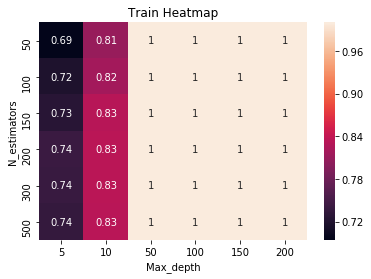

In [0]:
Plot_heatmap(train_auc,"Train Heatmap")

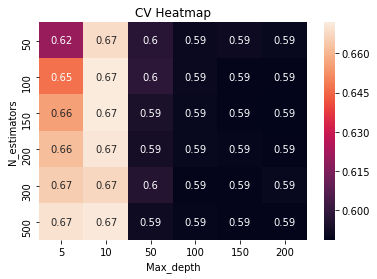

In [0]:
Plot_heatmap(cv_auc,"CV Heatmap")

Best parameter found
* n_estimators = 500
* max_depth = 5

**AUC Plot**

In [0]:
# probabilities calcultion
rf = RandomForestClassifier(n_estimators=500,max_depth=5,class_weight="balanced")
rf.fit(set1,y_train)
y1_predict_prob = rf.predict_proba(set1_t)[:,1]
y1_predict_prob_train = rf.predict_proba(set1)[:,1]

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#fpr,tpr 
fpr,tpr,thre = roc_curve(y_test,y1_predict_prob)

# am i doing it right here......?
fpr_train,tpr_train,thre_train = roc_curve(y_train,y1_predict_prob_train)


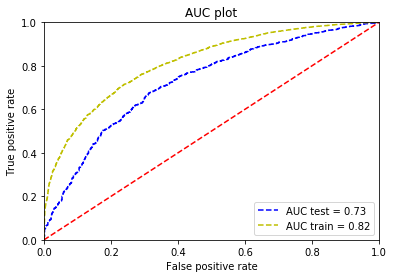

In [0]:
# auc calculation for test data
roc_auc1 = metrics.auc(fpr,tpr)

# auc calculation for train data
roc_auc_train1 = metrics.auc(fpr_train,tpr_train)

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.plot(fpr,tpr,"b--",label = 'AUC test = %0.2f'%roc_auc1)
plt.plot(fpr_train,tpr_train,"y--",label = 'AUC train = %0.2f'%roc_auc_train1)
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = "lower right")
plt.show()

**Confusion Matrix**

Text(0.5, 1.0, 'Confusion Matrix')

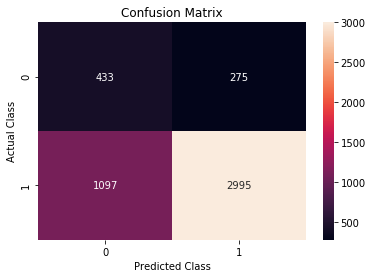

In [0]:
y_test_pred = rf.predict(set1_t)
cm1 = confusion_matrix(y_test,y_test_pred)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm1, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

### Set2 (TFIDF)

In [0]:
train_auc = []
cv_auc = []
heatmap = []
n_estimators = [50,100,150,200,300,500]
max_depth = [5, 10, 15,20]

for i in n_estimators:
    train_temp = []
    cv_temp = []
    for j in max_depth:
        rf = RandomForestClassifier(n_estimators=i,max_depth=j,class_weight="balanced")
        rf.fit(set2,y_train)

        y_train_pred = rf.predict(set2)  
        y_cv_pred = rf.predict(set2_v)

        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs        
        train_temp.append(roc_auc_score(y_train,y_train_pred))
        cv_temp.append(roc_auc_score(y_val, y_cv_pred))
    print("Completed = {}".format(i))
    train_auc.append(train_temp)
    cv_auc.append(cv_temp)

Completed = 50
Completed = 100
Completed = 150
Completed = 200
Completed = 300
Completed = 500


**Heatmap**

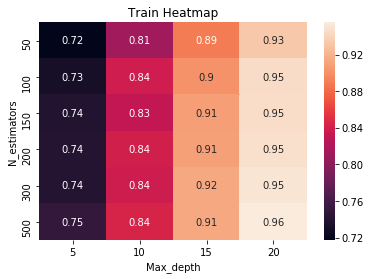

In [0]:
Plot_heatmap(train_auc,"Train Heatmap")

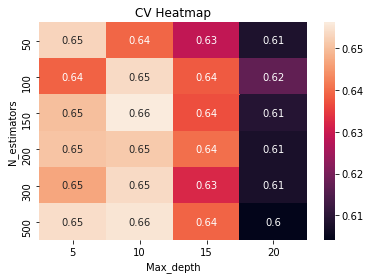

In [0]:
Plot_heatmap(cv_auc,"CV Heatmap")

Best parameter found
- n_estimators = 500
- max_depth = 5

**AUC Plot**

In [0]:
# probabilities calcultion
rf = RandomForestClassifier(n_estimators=500,max_depth=5,class_weight="balanced")
rf.fit(set2,y_train)

# probabilities calcultion
y2_predict_prob = rf.predict_proba(set2_t)[:,1]
y2_predict_prob_train = rf.predict_proba(set2)[:,1]

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#fpr,tpr 
fpr,tpr,thre = roc_curve(y_test,y2_predict_prob)

# am i doing it right here......?
fpr_train,tpr_train,thre_train = roc_curve(y_train,y2_predict_prob_train)


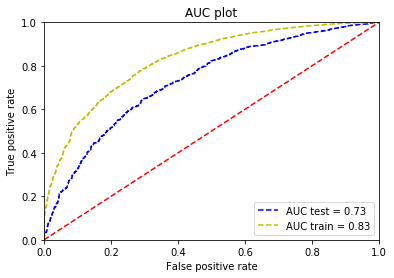

In [0]:
# auc calculation for test data
roc_auc2 = metrics.auc(fpr,tpr)

# auc calculation for train data
roc_auc_train2 = metrics.auc(fpr_train,tpr_train)

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.plot(fpr,tpr,"b--",label = 'AUC test = %0.2f'%roc_auc2)
plt.plot(fpr_train,tpr_train,"y--",label = 'AUC train = %0.2f'%roc_auc_train2)
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = "lower right")
plt.show()

**Confusion matrix**

Text(0.5, 1.0, 'Confusion Matrix')

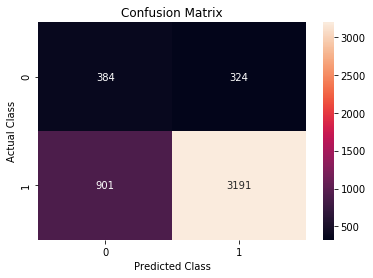

In [0]:
y2_predict = rf.predict(set2_t)
cm2 = confusion_matrix(y_test,y2_predict)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm2, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

### Set3 (Avg W2V)

In [0]:
train_auc = []
cv_auc = []
heatmap = []
n_estimators = [200,300,500,700]
max_depth = [5, 10, 15,20]

for i in n_estimators:
    train_temp = []
    cv_temp = []
    for j in max_depth:
        rf = RandomForestClassifier(n_estimators=i,max_depth=j,class_weight="balanced")
        rf.fit(set3,y_train)

        y_train_pred = rf.predict(set3)  
        y_cv_pred = rf.predict(set3_v)

        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs        
        train_temp.append(roc_auc_score(y_train,y_train_pred))
        cv_temp.append(roc_auc_score(y_val, y_cv_pred))
    print("Completed = {}".format(i))
    train_auc.append(train_temp)
    cv_auc.append(cv_temp)

Completed = 200
Completed = 300
Completed = 500
Completed = 700


**Heatmap**

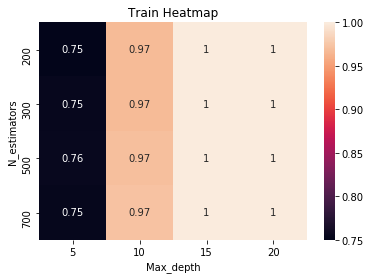

In [0]:
Plot_heatmap(train_auc,"Train Heatmap")

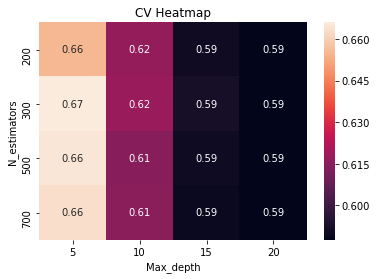

In [0]:
Plot_heatmap(cv_auc,"CV Heatmap")

Best Parameter found
- n_estimator = 700
- max_depth = 5

**AUC Plot**

In [0]:
# probabilities calcultion
rf = RandomForestClassifier(n_estimators=700,max_depth=5,class_weight="balanced")
rf.fit(set3,y_train)

# probabilities calcultion
y2_predict_prob = rf.predict_proba(set3_t)[:,1]
y2_predict_prob_train = rf.predict_proba(set3)[:,1]

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#fpr,tpr 
fpr,tpr,thre = roc_curve(y_test,y2_predict_prob)

# am i doing it right here......?
fpr_train,tpr_train,thre_train = roc_curve(y_train,y2_predict_prob_train)


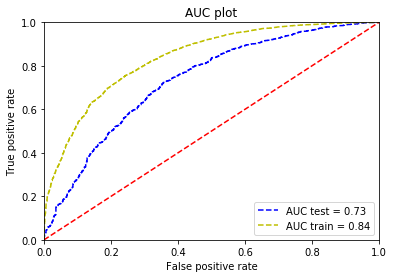

In [0]:
# auc calculation for test data
roc_auc3 = metrics.auc(fpr,tpr)

# auc calculation for train data
roc_auc_train3 = metrics.auc(fpr_train,tpr_train)

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.plot(fpr,tpr,"b--",label = 'AUC test = %0.2f'%roc_auc3)
plt.plot(fpr_train,tpr_train,"y--",label = 'AUC train = %0.2f'%roc_auc_train3)
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = "lower right")
plt.show()

**confusion matrix**

Text(0.5, 1.0, 'Confusion Matrix')

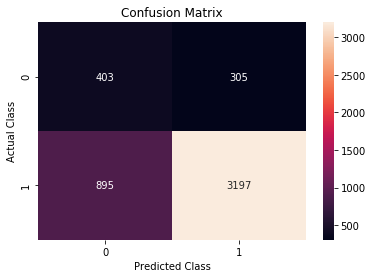

In [0]:
y3_predict = rf.predict(set3_t)
cm3 = confusion_matrix(y_test,y3_predict)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm3, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

### Set4 (TFIDF Avg_w2v)

In [0]:
train_auc = []
cv_auc = []
heatmap = []
n_estimators = [100,200,300,500]
max_depth = [5, 10, 15,20]

for i in n_estimators:
    train_temp = []
    cv_temp = []
    for j in max_depth:
        rf = RandomForestClassifier(n_estimators=i,max_depth=j,class_weight="balanced")
        rf.fit(set4,y_train)

        y_train_pred = rf.predict(set4)  
        y_cv_pred = rf.predict(set4_v)

        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs        
        train_temp.append(roc_auc_score(y_train,y_train_pred))
        cv_temp.append(roc_auc_score(y_val, y_cv_pred))
    print("Completed = {}".format(i))
    train_auc.append(train_temp)
    cv_auc.append(cv_temp)

Completed = 100
Completed = 150
Completed = 200
Completed = 300
Completed = 500


**Heatmap**

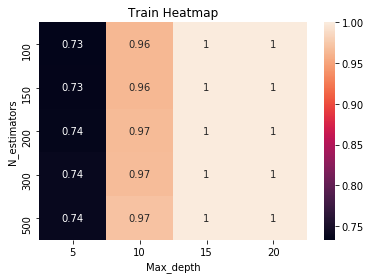

In [0]:
Plot_heatmap(train_auc,"Train Heatmap")

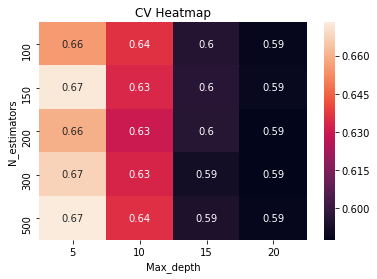

In [0]:
Plot_heatmap(cv_auc,"CV Heatmap")

**AUC Plot**

In [0]:
# probabilities calcultion
rf = RandomForestClassifier(n_estimators=500,max_depth=5,class_weight="balanced")
rf.fit(set4,y_train)

# probabilities calcultion
y2_predict_prob = rf.predict_proba(set4_t)[:,1]
y2_predict_prob_train = rf.predict_proba(set4)[:,1]

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#fpr,tpr 
fpr,tpr,thre = roc_curve(y_test,y2_predict_prob)

# am i doing it right here......?
fpr_train,tpr_train,thre_train = roc_curve(y_train,y2_predict_prob_train)


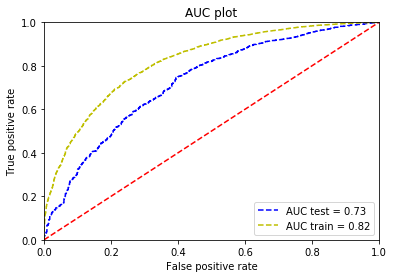

In [0]:
# auc calculation for test data
roc_auc4 = metrics.auc(fpr,tpr)

# auc calculation for train data
roc_auc_train4 = metrics.auc(fpr_train,tpr_train)

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.plot(fpr,tpr,"b--",label = 'AUC test = %0.2f'%roc_auc4)
plt.plot(fpr_train,tpr_train,"y--",label = 'AUC train = %0.2f'%roc_auc_train4)
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = "lower right")
plt.show()

**Confusion Matrix**

Text(0.5, 1.0, 'Confusion Matrix')

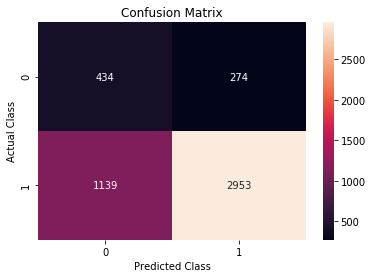

In [0]:
y4_predict = rf.predict(set4_t)
cm1 = confusion_matrix(y_test,y4_predict)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm1, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

### Observation
=======================

1. TFIDF found to be best Vectorizer
2. Best **train AUC of 0.72** and **test auc of 0.83** was found in case of TFIDF
3. Overfitting in model found for higher values of max_depth

### Summary of RF

In [0]:
from prettytable import PrettyTable
summary = PrettyTable()

In [0]:
summary.field_names = ["Set", "Vectorizer", "Model", "Hyperparameter","Test","Train"]

In [0]:
summary.add_row(["set1","BOW","RF","max_depth': 5, 'n_estimators': 500","%0.3f"%roc_auc1,"%0.3f"%roc_auc_train1])
summary.add_row(["set2","TFIDF","RF","'max_depth': 5, 'n_estimators': 500","%0.3f"%roc_auc2,"%0.3f"%roc_auc_train2])
summary.add_row(["set3","Avg-W2v","RF","'max_depth': 5, 'n_estimators': 500","%0.3f"%roc_auc3,"%0.3f"%roc_auc_train3])
summary.add_row(["set4","TFIDF W2V","RF","'max_depth': 5, 'n_estimators': 500","%0.3f"%roc_auc4,"%0.3f"%roc_auc_train4])


print(summary)

+------+------------+-------+-------------------------------------+-------+-------+
| Set  | Vectorizer | Model |            Hyperparameter           |  Test | Train |
+------+------------+-------+-------------------------------------+-------+-------+
| set1 |    BOW     |   RF  |  max_depth': 5, 'n_estimators': 500 | 0.728 | 0.816 |
| set2 |   TFIDF    |   RF  | 'max_depth': 5, 'n_estimators': 500 | 0.732 | 0.827 |
| set3 |  Avg-W2v   |   RF  | 'max_depth': 5, 'n_estimators': 500 | 0.733 | 0.838 |
| set4 | TFIDF W2V  |   RF  | 'max_depth': 5, 'n_estimators': 500 | 0.726 | 0.820 |
+------+------------+-------+-------------------------------------+-------+-------+


## GBDT

- Tuned over wide range of below parameters of XGBOOST. 
   - max_depth = [4,5,10,1215,20,30,50]
   - min_child_weight = [2,4,6]
   - n_estimators = [100,200,500]
   
   
 - Showing results for short range

In [0]:
def Plot_heatmap(mean_score,name):
    """
    This function plots heatmap.
    """
    df = pd.DataFrame(mean_score,index = max_depth,columns = min_child_weight)
    sns.heatmap(df,annot = True)
    plt.ylabel("max_depth")
    plt.xlabel("min_child_weight")
    plt.title(name)
    plt.show()
    

### Set1 BOW

In [0]:
train_auc = []
cv_auc = []

max_depth = [5,10,12,15]
min_child_weight = [3,4,5]

for i in max_depth:
    train_temp = []
    cv_temp = []
    for j in min_child_weight:
        xgb = XGBClassifier(learning_rate=0.05,max_depth=i,min_child_weight=j,n_estimators=100)
        xgb.fit(set1,y_train)

        y_train_pred = xgb.predict(set1)  
        y_cv_pred = xgb.predict(set1_v)

  
        train_temp.append(roc_auc_score(y_train,y_train_pred))
        cv_temp.append(roc_auc_score(y_val, y_cv_pred))
    print("Completed = {}".format(i))
    train_auc.append(train_temp)
    cv_auc.append(cv_temp)

Completed = 5
Completed = 10
Completed = 12
Completed = 15


**Heatmap**

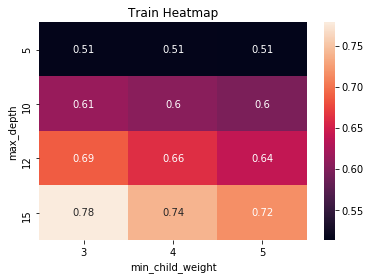

In [0]:
Plot_heatmap(train_auc,"Train Heatmap")

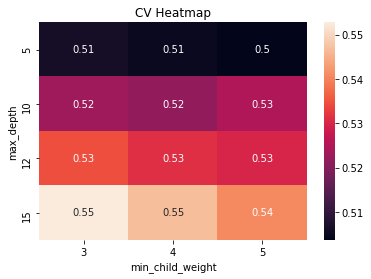

In [0]:
Plot_heatmap(cv_auc,"CV Heatmap")

Best paramter found:
- learning_rate = 0.07
- max_depth = 4
- min_child_weight = 4
- n_estimators = 200

**AUC Plot**

In [0]:
# probabilities calcultion
xgb = XGBClassifier(learning_rate=0.07,max_depth=4,min_child_weight=4,n_estimators=200)
xgb.fit(set1,y_train)
y1_predict_prob = xgb.predict_proba(set1_t)[:,1]
y1_predict_prob_train = xgb.predict_proba(set1)[:,1]

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#fpr,tpr 
fpr,tpr,thre = roc_curve(y_test,y1_predict_prob)

# am i doing it right here......?
fpr_train,tpr_train,thre_train = roc_curve(y_train,y1_predict_prob_train)


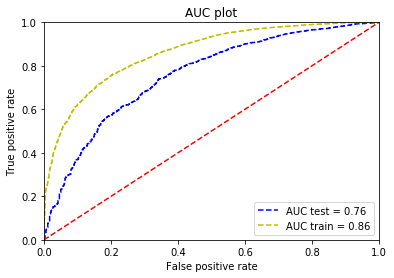

In [0]:
# auc calculation for test data
roc_auc1 = metrics.auc(fpr,tpr)

# auc calculation for train data
roc_auc_train1 = metrics.auc(fpr_train,tpr_train)

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.plot(fpr,tpr,"b--",label = 'AUC test = %0.2f'%roc_auc1)
plt.plot(fpr_train,tpr_train,"y--",label = 'AUC train = %0.2f'%roc_auc_train1)
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = "lower right")
plt.show()


**Confusion Matrix**

Text(0.5, 1.0, 'Confusion Matrix')

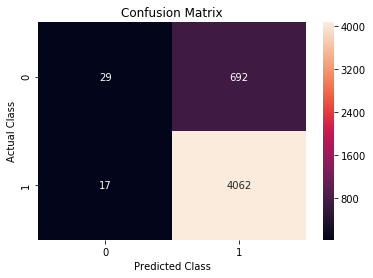

In [0]:
y1_predict = xgb.predict(set1_t)
cm1 = confusion_matrix(y_test,y1_predict)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm1, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

### Set2 (TFIDF)

In [0]:
train_auc = []
cv_auc = []

max_depth = [4,5,10,12]
min_child_weight = [3,4,5]

for i in max_depth:
    train_temp = []
    cv_temp = []
    for j in min_child_weight:
        xgb = XGBClassifier(learning_rate=0.07,max_depth=i,min_child_weight=j,n_estimators=100)
        xgb.fit(set2,y_train)

        y_train_pred = xgb.predict(set2)  
        y_cv_pred = xgb.predict(set2_v)

        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs        
        train_temp.append(roc_auc_score(y_train,y_train_pred))
        cv_temp.append(roc_auc_score(y_val, y_cv_pred))
    print("Completed = {}".format(i))
    train_auc.append(train_temp)
    cv_auc.append(cv_temp)

Completed = 4
Completed = 5
Completed = 10
Completed = 12


**Heatmap**

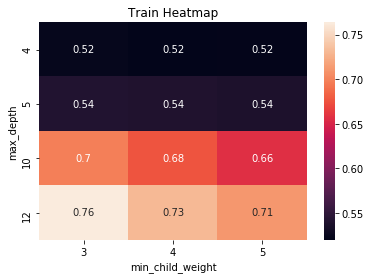

In [0]:
Plot_heatmap(train_auc,"Train Heatmap")

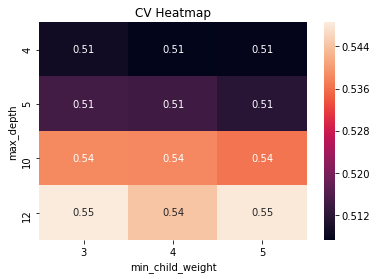

In [0]:
Plot_heatmap(cv_auc,"CV Heatmap")

Best paramter found:
- learning_rate = 0.07
- max_depth = 4
- min_child_weight = 4
- n_estimators = 200

**AUC Plot**

In [0]:
# probabilities calcultion
xgb = XGBClassifier(learning_rate=0.07,max_depth=4,min_child_weight=4,n_estimators=200)
xgb.fit(set2,y_train)
y1_predict_prob = xgb.predict_proba(set2_t)[:,1]
y1_predict_prob_train = xgb.predict_proba(set2)[:,1]

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#fpr,tpr 
fpr,tpr,thre = roc_curve(y_test,y1_predict_prob)

# am i doing it right here......?
fpr_train,tpr_train,thre_train = roc_curve(y_train,y1_predict_prob_train)


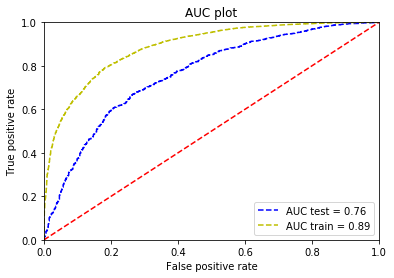

In [0]:
# auc calculation for test data
roc_auc2 = metrics.auc(fpr,tpr)

# auc calculation for train data
roc_auc_train2 = metrics.auc(fpr_train,tpr_train)

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.plot(fpr,tpr,"b--",label = 'AUC test = %0.2f'%roc_auc2)
plt.plot(fpr_train,tpr_train,"y--",label = 'AUC train = %0.2f'%roc_auc_train2)
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = "lower right")
plt.show()

**Confusion Matrix**

Text(0.5, 1.0, 'Confusion Matrix')

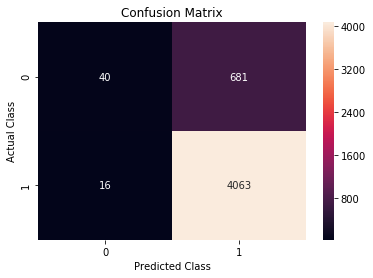

In [0]:
y2_predict = xgb.predict(set2_t)
cm2 = confusion_matrix(y_test,y2_predict)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm2, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

### SET3

In [0]:
train_auc = []
cv_auc = []

max_depth = [4,5,10,12]
min_child_weight = [3,4,5]

for i in max_depth:
    train_temp = []
    cv_temp = []
    for j in min_child_weight:
        xgb = XGBClassifier(learning_rate=0.07,max_depth=i,min_child_weight=j,n_estimators=100)
        xgb.fit(set3,y_train)

        y_train_pred = xgb.predict(set3)  
        y_cv_pred = xgb.predict(set3_v)

        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs        
        train_temp.append(roc_auc_score(y_train,y_train_pred))
        cv_temp.append(roc_auc_score(y_val, y_cv_pred))
    print("Completed = {}".format(i))
    train_auc.append(train_temp)
    cv_auc.append(cv_temp)

Completed = 4
Completed = 5
Completed = 10
Completed = 12


**Heatmap**

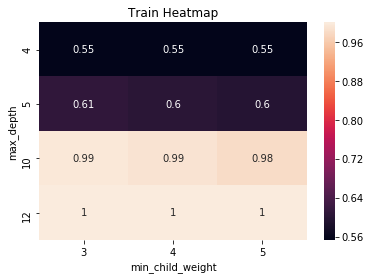

In [0]:
Plot_heatmap(train_auc,"Train Heatmap")

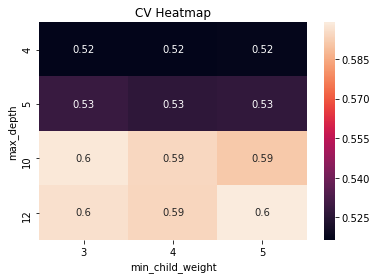

In [0]:
Plot_heatmap(cv_auc,"CV Heatmap")

Best paramter found:
- learning_rate = 0.07
- max_depth = 4
- min_child_weight = 4
- n_estimators = 100

**AUC Plot**

In [0]:
# probabilities calcultion
xgb = XGBClassifier(learning_rate=0.07,max_depth=4,min_child_weight=4,n_estimators=100)
xgb.fit(set3,y_train)
y1_predict_prob = xgb.predict_proba(set3_t)[:,1]
y1_predict_prob_train = xgb.predict_proba(set3)[:,1]

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#fpr,tpr 
fpr,tpr,thre = roc_curve(y_test,y1_predict_prob)

# am i doing it right here......?
fpr_train,tpr_train,thre_train = roc_curve(y_train,y1_predict_prob_train)


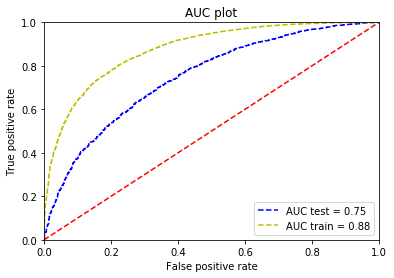

In [0]:
# auc calculation for test data
roc_auc3 = metrics.auc(fpr,tpr)

# auc calculation for train data
roc_auc_train3 = metrics.auc(fpr_train,tpr_train)

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.plot(fpr,tpr,"b--",label = 'AUC test = %0.2f'%roc_auc3)
plt.plot(fpr_train,tpr_train,"y--",label = 'AUC train = %0.2f'%roc_auc_train3)
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = "lower right")
plt.show()

**Confusion Matrix**

Text(0.5, 1.0, 'Confusion Matrix')

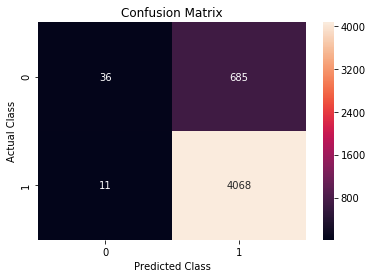

In [0]:
y3_predict = xgb.predict(set3_t)
cm3 = confusion_matrix(y_test,y3_predict)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm3, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

### Set 4

In [0]:
train_auc = []
cv_auc = []

max_depth = [4,5,10,12]
min_child_weight = [3,4,5]

for i in max_depth:
    train_temp = []
    cv_temp = []
    for j in min_child_weight:
        xgb = XGBClassifier(learning_rate=0.07,max_depth=4,min_child_weight=4,n_estimators=100)
        xgb.fit(set4,y_train)

        y_train_pred = xgb.predict(set4)  
        y_cv_pred = xgb.predict(set4_v)

        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs        
        train_temp.append(roc_auc_score(y_train,y_train_pred))
        cv_temp.append(roc_auc_score(y_val, y_cv_pred))
    print("Completed = {}".format(i))
    train_auc.append(train_temp)
    cv_auc.append(cv_temp)

Completed = 4
Completed = 5
Completed = 10
Completed = 12


**Heatmap**

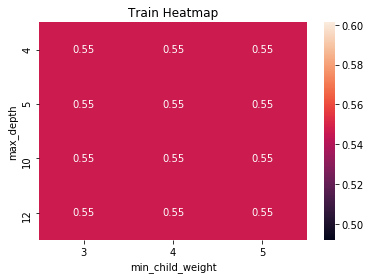

In [0]:
Plot_heatmap(train_auc,"Train Heatmap")

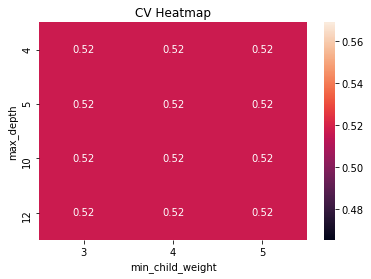

In [0]:
Plot_heatmap(cv_auc,"CV Heatmap")

Best paramter found:
- learning_rate = 0.07
- max_depth = 4
- min_child_weight = 4
- n_estimators = 100

**AUC Plot**

In [0]:
# probabilities calcultion
xgb = XGBClassifier(learning_rate=0.07,max_depth=4,min_child_weight=4,n_estimators=100)
xgb.fit(set4,y_train)
y1_predict_prob = xgb.predict_proba(set4_t)[:,1]
y1_predict_prob_train = xgb.predict_proba(set4)[:,1]

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#fpr,tpr 
fpr,tpr,thre = roc_curve(y_test,y1_predict_prob)

# am i doing it right here......?
fpr_train,tpr_train,thre_train = roc_curve(y_train,y1_predict_prob_train)


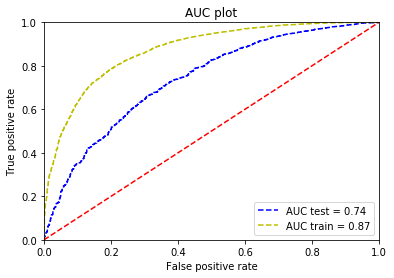

In [0]:
# auc calculation for test data
roc_auc4 = metrics.auc(fpr,tpr)

# auc calculation for train data
roc_auc_train4 = metrics.auc(fpr_train,tpr_train)

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.plot(fpr,tpr,"b--",label = 'AUC test = %0.2f'%roc_auc4)
plt.plot(fpr_train,tpr_train,"y--",label = 'AUC train = %0.2f'%roc_auc_train4)
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = "lower right")
plt.show()

**Confusion Matrix**

Text(0.5, 1.0, 'Confusion Matrix')

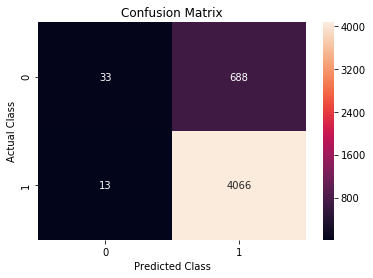

In [0]:
y4_predict = xgb.predict(set4_t)
cm4 = confusion_matrix(y_test,y4_predict)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(cm4, annot=True, fmt="d")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix")

### Obseravtion:
================

1. **max_depth** found to be most important parameter in tuning xgboost
2. For given max_depth and min_child_weight increase in n_estimators was leading to overfitting the model.
3. Best results was found in case of TFIDF vectorizer.
4. Tuning Avg-W2V and TFIDF-W2V took more time as compared to others.
5. Best learning_rate of 0.07 was found for all the cases.

### Summary

In [0]:
from prettytable import PrettyTable
summary = PrettyTable()

In [0]:
summary.field_names = ["Set", "Vectorizer", "Model", "Hyperparameter","Test","Train"]

In [0]:
summary.add_row(["set1","BOW","XGBOOST","lr = 0.07 ,max_depth = 5,min_child_weight = 4,n_estimators = 200","%0.3f"%roc_auc1,"%0.3f"%roc_auc_train1])
summary.add_row(["set2","TFIDF","XGBOOST","lr = 0.07, max_depth=4,min_child_weight = 4,n_estimators=200","%0.3f"%roc_auc2,"%0.3f"%roc_auc_train2])
summary.add_row(["set3","Avg-W2v","XGBOOST","lr = 0.07, max_depth=4,min_child_weight = 4,n_estimators=100","%0.3f"%roc_auc3,"%0.3f"%roc_auc_train3])
summary.add_row(["set4","TFIDF W2V","XGBOOST","lr = 0.07, max_depth=4,min_child_weight = 4,n_estimators=200","%0.3f"%roc_auc4,"%0.3f"%roc_auc_train4])


print(summary)

+------+------------+---------+------------------------------------------------------------------+-------+-------+
| Set  | Vectorizer |  Model  |                          Hyperparameter                          |  Test | Train |
+------+------------+---------+------------------------------------------------------------------+-------+-------+
| set1 |    BOW     | XGBOOST | lr = 0.07 ,max_depth = 5,min_child_weight = 4,n_estimators = 200 | 0.758 | 0.862 |
| set2 |   TFIDF    | XGBOOST |   lr = 0.07, max_depth=4,min_child_weight = 4,n_estimators=200   | 0.762 | 0.888 |
| set3 |  Avg-W2v   | XGBOOST |   lr = 0.07, max_depth=4,min_child_weight = 4,n_estimators=100   | 0.748 | 0.876 |
| set4 | TFIDF W2V  | XGBOOST |   lr = 0.07, max_depth=4,min_child_weight = 4,n_estimators=200   | 0.738 | 0.874 |
+------+------------+---------+------------------------------------------------------------------+-------+-------+
